In [1]:
import os


import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression as LR

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def single_mouse_rev_arrays(concat_sess):
    cellmask = concat_sess.fam_place_cell_mask() + concat_sess.nov_place_cell_mask()>0

    b_mask = (concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['sess_num']==6)
    b_mask[concat_sess.trial_info['sess_num']<6 ] =True
    ret_mask = (concat_sess.trial_info['block_number']>1)*(concat_sess.trial_info['sess_num']==8)
    rev_mask = (concat_sess.trial_info['sess_num']==7)*(concat_sess.trial_info['block_number']>2)
    rev_mask[(concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['sess_num']==8)] = True #(~b_mask)*(~ret_mask)
#     rev_mask =  (concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['sess_num']==8) 
    
    l_b_mask, r_b_mask = b_mask*(concat_sess.trial_info['LR']==-1), b_mask*(concat_sess.trial_info['LR']==1)
    l_rev_mask, r_rev_mask = rev_mask*(concat_sess.trial_info['LR']==-1), rev_mask*(concat_sess.trial_info['LR']==1)
    l_ret_mask, r_ret_mask = ret_mask*(concat_sess.trial_info['LR']==-1), ret_mask*(concat_sess.trial_info['LR']==1)


    trial_mat = concat_sess.trial_matrices['spks_norm'][:,:,cellmask]
#     trial_mat = trial_mat[:,:,:]
#     trial_mat = sp.ndimage.filters.gaussian_filter1d(trial_mat,1,axis=1)

    # baseline sort
    _l_b_tmat, _r_b_tmat = trial_mat[l_b_mask,:,:], trial_mat[r_b_mask,:, :]
    


    # reversal endpoint sort
    _l_rev_tmat, _r_rev_tmat = trial_mat[l_rev_mask,:,:], trial_mat[r_rev_mask,:, :]
#     _l_rev_tmat, _r_rev_tmat = _l_rev_tmat[-20:,:,:], _r_rev_tmat[-20:,:,:]

    # return sort
    _l_ret_tmat, _r_ret_tmat = trial_mat[l_ret_mask,:,:], trial_mat[r_ret_mask,:, :]
    
    return {'b_l_all': np.nanmean(_l_b_tmat, axis=0),
            'b_r_all': np.nanmean(_r_b_tmat , axis=0),
            'b_l_odd': np.nanmean(_l_b_tmat[::2,:,:], axis=0),
            'b_r_odd': np.nanmean(_r_b_tmat[::2,:,:], axis=0),
            'b_l_even': np.nanmean(_l_b_tmat[1::2,:,:], axis=0),
            'b_r_even': np.nanmean(_r_b_tmat[1::2,:,:], axis=0),
                
            'rev_l_all': np.nanmean(_l_rev_tmat, axis=0),
            'rev_r_all': np.nanmean(_r_rev_tmat, axis=0),
            'rev_l_odd': np.nanmean(_l_rev_tmat[::2,:,:], axis=0),
            'rev_r_odd': np.nanmean(_r_rev_tmat[::2,:,:], axis=0),
            'rev_l_even': np.nanmean(_l_rev_tmat[1::2,:,:], axis=0),
            'rev_r_even':np.nanmean(_r_rev_tmat[1::2,:,:], axis=0),
            
            'ret_l_all': np.nanmean(_l_ret_tmat, axis=0),
            'ret_r_all': np.nanmean(_r_ret_tmat, axis=0),
            'ret_l_odd': np.nanmean(_l_ret_tmat[::2,:,:], axis=0),
            'ret_r_odd': np.nanmean(_r_ret_tmat[::2,:,:], axis=0),
            'ret_l_even': np.nanmean(_l_ret_tmat[1::2,:,:], axis=0),
            'ret_r_even': np.nanmean(_r_ret_tmat[1::2,:,:], axis=0),
           }
            

def rev_arrays(mice, concat = True):

    res = {'b_l_all': [],
            'b_r_all': [],
            'b_l_odd': [],
            'b_r_odd': [],
            'b_l_even':[],
            'b_r_even':[],
                
            'rev_l_all': [],
            'rev_r_all': [],
            'rev_l_odd': [],
            'rev_r_odd': [],
            'rev_l_even': [],
            'rev_r_even': [],
            
            'ret_l_all': [], 
            'ret_r_all': [], 
            'ret_l_odd': [], 
            'ret_r_odd': [], 
            'ret_l_even': [], 
            'ret_r_even': [],
           }
    
    for mouse in mice:
        _res = single_mouse_rev_arrays(u.single_mouse_concat_sessions(mouse, date_inds = [5, 6,7,8]))
        
        for k,v in _res.items():
            res[k].append(v)
    
    if concat:
        for k,v in res.items():
            res[k] = np.concatenate(v,axis=-1)
            
    return res
        






In [3]:
ctrl_arrays = rev_arrays(ctrl_mice)
ko_arrays = rev_arrays(ko_mice[1:])

KeyError: 'novel'

In [ ]:
sess = u.load_single_day(ctrl_mice[0],0)

In [ ]:
ko_b_max, ko_rev_max = np.argmax(ko_arrays['b_l_all'],axis=0), np.argmax(ko_arrays['rev_l_all'],axis=0)
# ko_b_max, ko_rev_max = stx.spatial_analyses.spatial_com(ko_arrays['b_l_all'].T), stx.spatial_analyses.spatial_com(ko_arrays['rev_l_all'].T)
ctrl_b_max, ctrl_rev_max = np.argmax(ctrl_arrays['b_l_all'],axis=0), np.argmax(ctrl_arrays['rev_l_all'],axis=0)
# ctrl_b_max, ctrl_rev_mask = stx.spatial_analyses.spatial_com(ctrl_arrays['b_l_all']), stx.spatial_analyses.spatial_com(ctrl_arrays['rev_l_all'])

fig,ax = plt.subplots(2, 3, figsize = [15,10])
bins = np.arange(0,31)
# x = np.linspace(0,31)[:,np.newaxis]
# max2d = np.array([b_max, rev_max]).T
# print(max2d.shape)
print(ko_b_max.shape)
def get_smooth_hist(b_max, rev_max):
    hist, xedges, yedges = np.histogram2d(b_max,rev_max, bins = [bins, bins], density = False)
    hist_sm = sp.ndimage.filters.gaussian_filter(hist, (1,1))
    hist_sm /= hist_sm.ravel().sum()
    return hist_sm

# ax[0,0].hist(ctrl_b_max-ctrl_rev_max,bins=bins,color='black', alpha = .3, density=True, cumulative=True)
# ax[0,0].hist(ko_b_max-ko_rev_max,bins=bins, alpha=.3, color='red', density=True, cumulative=True)
l_ctrl_hist_sm = get_smooth_hist(ctrl_b_max,ctrl_rev_max)
ax[0,0].imshow(l_ctrl_hist_sm, vmin=.001, vmax = .003, cmap='RdPu')

l_ko_hist_sm = get_smooth_hist(ko_b_max,ko_rev_max)
ax[0,1].imshow(l_ko_hist_sm, vmin=.001, vmax = .003, cmap='RdPu')

ax[0,2].imshow(l_ctrl_hist_sm-l_ko_hist_sm, cmap='RdGy', vmin=-.002, vmax= .002)


ko_b_max, ko_rev_max = np.argmax(ko_arrays['b_r_all'],axis=0), np.argmax(ko_arrays['rev_r_all'],axis=0)
ctrl_b_max, ctrl_rev_max = np.argmax(ctrl_arrays['b_r_all'],axis=0), np.argmax(ctrl_arrays['rev_r_all'],axis=0)

r_ctrl_hist_sm = get_smooth_hist(ctrl_b_max,ctrl_rev_max)
ax[1,0].imshow(r_ctrl_hist_sm, vmin=.001, vmax = .003, cmap='RdPu')

r_ko_hist_sm = get_smooth_hist(ko_b_max,ko_rev_max)
ax[1,1].imshow(r_ko_hist_sm, vmin=.001, vmax = .003, cmap='RdPu')

ax[1,2].imshow(r_ctrl_hist_sm-r_ko_hist_sm, cmap='RdGy', vmin=-.002, vmax= .002)


rz_early = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_early['tfront'])[0], np.argwhere(sess.rzone_early['tback']<=sess.trial_matrices['bin_edges'][1:])[0] )
rz_late = (np.argwhere(sess.trial_matrices['bin_edges'][:-1]>=sess.rzone_late['tfront'])[0], 29 )
print(rz_early,rz_late)
for col in range(3):
    ax[0,col].fill_between(np.linspace(-.5,29.5), rz_early[0], rz_early[1],  alpha=.3, hatch = '/', color='none', edgecolor='blue')
    ax[0,col].fill_betweenx(np.linspace(-.5,29.5), rz_late[0], rz_late[1],  alpha=.3, color='blue')
    
    ax[1,col].fill_betweenx(np.linspace(-.5,29.5), rz_early[0], rz_early[1],  alpha=.3, color='green')
    ax[1,col].fill_between(np.linspace(-.5,29.5), rz_late[0], rz_late[1],  alpha=.3, hatch= '/', color='none', edgecolor='green')


In [ ]:
fig,ax = plt.subplots()
ko_ = l_ko_hist_sm[15:20,10:].sum(axis=0)
ax.plot(ko_/ko_.sum(),color='red')
ctrl_ = l_ctrl_hist_sm[15:20,10:].sum(axis=0)
ax.plot(ctrl_/ctrl_.sum(),color='black')

In [ ]:
fig,ax = plt.subplots()
ko_ = r_ko_hist_sm[10:,15:20].sum(axis=1)
ax.plot(ko_/ko_.sum(),color='red')
ctrl_ = r_ctrl_hist_sm[10:, 15:20].sum(axis=1)
ax.plot(ctrl_/ctrl_.sum(),color='black')

In [4]:
ctrl_arrays.keys()

NameError: name 'ctrl_arrays' is not defined

In [5]:
def reversal_plots(arrays):

    fig_l, ax = plt.subplots(3,3, figsize=[10,15])

    b_l_sort = np.argsort(np.argmax(arrays['b_l_odd'],axis=0))
    b_l_mu, b_l_std = np.nanmean(arrays['b_l_odd'],axis=0, keepdims=True), np.nanstd(arrays['b_l_odd'], axis=0, keepdims=True)
    b_l_plot = (arrays['b_l_even']-b_l_mu)/b_l_std
    ax[0,0].imshow(b_l_plot[:,b_l_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')
    

#     rev_b_l_plot = (arrays['rev_l_all']-b_l_mu)/b_l_std
    rev_b_l_plot = sp.stats.zscore(arrays['rev_l_all'],axis=0)
    ax[0,1].imshow(rev_b_l_plot[:,b_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')
    

#     ret_b_l_plot = (arrays['ret_l_all']-b_l_mu)/b_l_std
    ret_b_l_plot = sp.stats.zscore(arrays['ret_l_all'],axis=0)
    ax[0,2].imshow(ret_b_l_plot[:,b_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')
    


    rev_l_sort = np.argsort(np.argmax(arrays['rev_l_odd'],axis=0))
#     rev_l_mu, rev_l_std = np.nanmean(arrays['rev_l_odd'],axis=0, keepdims=True), np.nanstd(arrays['rev_l_odd'], axis=0, keepdims=True)
#     rev_l_plot = (arrays['rev_l_even']-rev_l_mu)/rev_l_std
    rev_l_plot = sp.stats.zscore(arrays['rev_l_even'], axis = 0)
    ax[1,1].imshow(rev_l_plot[:,rev_l_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')

#     b_rev_l_plot = (arrays['b_l_all']-rev_l_mu)/rev_l_std
    b_rev_l_plot = sp.stats.zscore(arrays['b_l_all'],axis=0)
    ax[1,0].imshow(b_rev_l_plot[:,rev_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

#     ret_rev_l_plot = (arrays['ret_l_all']-rev_l_mu)/rev_l_std
    ret_rev_l_plot = sp.stats.zscore(arrays['ret_l_all'], axis=0)
    ax[1,2].imshow(ret_rev_l_plot[:,rev_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')


    ret_l_sort = np.argsort(np.argmax(arrays['ret_l_odd'],axis=0))
#     ret_l_mu, ret_l_std = np.nanmean(arrays['ret_l_odd'],axis=0, keepdims=True), np.nanstd(arrays['ret_l_odd'], axis=0, keepdims=True)
#     ret_l_plot = (arrays['ret_l_even']-ret_l_mu)/ret_l_std
    ret_l_plot = sp.stats.zscore(arrays['ret_l_even'], axis = 0)
    ax[2,2].imshow(ret_l_plot[:,ret_l_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')

#     b_ret_l_plot = (arrays['b_l_all']-ret_l_mu)/ret_l_std
    b_ret_l_plot = sp.stats.zscore(arrays['b_l_all'], axis=0)
    ax[2,0].imshow(b_ret_l_plot[:,ret_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

#     rev_ret_l_plot = (arrays['rev_l_all']-ret_l_mu)/ret_l_std
    rev_ret_l_plot = sp.stats.zscore(arrays['rev_l_all'],axis=0)
    ax[2,1].imshow(rev_ret_l_plot[:,ret_l_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

    for r in range(3):
        for c in range(3):
            ax[r,c,].plot([-.5,29.5], [0,b_l_plot.shape[1]-1], color='blue', linewidth=3)

    ######
    fig_r, ax = plt.subplots(3,3, figsize=[10,15])

    b_r_sort = np.argsort(np.argmax(arrays['b_r_odd'],axis=0))
#     b_r_mu, b_r_std = np.nanmean(arrays['b_r_odd'],axis=0, keepdims=True), np.nanstd(arrays['b_r_odd'], axis=0, keepdims=True)
#     b_r_plot = (arrays['b_r_even']-b_r_mu)/b_r_std
    b_r_plot = sp.stats.zscore(arrays['b_r_even'], axis=0)
    ax[0,0].imshow(b_r_plot[:,b_r_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')

#     rev_b_r_plot = (arrays['rev_r_all']-b_r_mu)/b_r_std
    rev_b_r_plot = sp.stats.zscore(arrays['rev_r_all'], axis =0)
    ax[0,1].imshow(rev_b_r_plot[:,b_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

#     ret_b_r_plot = (arrays['ret_r_all']-b_r_mu)/b_r_std
    ret_b_r_plot = sp.stats.zscore(arrays['ret_r_all'], axis = 0)
    ax[0,2].imshow(ret_b_r_plot[:,b_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')


    rev_r_sort = np.argsort(np.argmax(arrays['rev_r_odd'],axis=0))
#     rev_r_mu, rev_r_std = np.nanmean(arrays['rev_r_odd'],axis=0, keepdims=True), np.nanstd(arrays['rev_r_odd'], axis=0, keepdims=True)
#     rev_r_plot = (arrays['rev_r_even']-rev_r_mu)/rev_r_std
    rev_r_plot = sp.stats.zscore(arrays['rev_r_even'], axis=0)
    ax[1,1].imshow(rev_r_plot[:,rev_r_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')

#     b_rev_r_plot = (arrays['b_r_all']-rev_r_mu)/rev_r_std
    b_rev_r_plot = sp.stats.zscore(arrays['b_r_all'], axis = 0)
    ax[1,0].imshow(b_rev_l_plot[:,rev_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

#     ret_rev_r_plot = (arrays['ret_r_all']-rev_r_mu)/rev_r_std
    ret_rev_r_plot = sp.stats.zscore(arrays['ret_r_all'], axis=0)
    ax[1,2].imshow(ret_rev_r_plot[:,rev_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')


    ret_r_sort = np.argsort(np.argmax(arrays['ret_r_odd'],axis=0))
#     ret_r_mu, ret_r_std = np.nanmean(arrays['ret_r_odd'],axis=0, keepdims=True), np.nanstd(arrays['ret_r_odd'], axis=0, keepdims=True)
#     ret_r_plot = (arrays['ret_r_even']-ret_r_mu)/ret_r_std
    ret_r_plot = sp.stats.zscore(arrays['ret_r_even'],axis = 0)
    ax[2,2].imshow(ret_r_plot[:,ret_r_sort].T,cmap='pink',vmin=0,vmax=3, aspect='auto')

#     b_ret_r_plot = (arrays['b_r_all']-ret_r_mu)/ret_r_std
    b_ret_r_plot = sp.stats.zscore(arrays['b_r_all'], axis=0)
    ax[2,0].imshow(b_ret_r_plot[:,ret_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')

#     rev_ret_r_plot = (arrays['rev_r_all']-ret_r_mu)/ret_r_std
    rev_ret_r_plot = sp.stats.zscore(arrays['rev_r_all'],axis = 0)
    ax[2,1].imshow(rev_ret_r_plot[:,ret_r_sort].T, cmap = 'pink', vmin=0, vmax=3, aspect='auto')
    
    for r in range(3):
        for c in range(3):
            ax[r,c,].plot([-.5,29.5], [0,b_r_plot.shape[1]-1], color='blue', linewidth=3)
            
    return fig_l, fig_r


In [6]:
ko_fig_l, ko_fig_r = reversal_plots(ko_arrays)
ctrl_fig_l, ctrl_fig_r = reversal_plots(ctrl_arrays)

NameError: name 'ko_arrays' is not defined

In [36]:
ctrl_arrays = rev_arrays(ctrl_mice, concat = False)
ko_arrays = rev_arrays(ko_mice[1:], concat = False)

04_12_2020 YMaze_LNovel
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
06_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_12_2020 YMaze_LNovel
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
06_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_12_2020 YMaze_LNovel
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
06_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_12_2020 YMaze_LNovel
06_12_2020 YMaze_LNovel
06_12_2020 YMaze_RewardReversal
06_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_LNovel
['LR', 'bl

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
06_12_2020 YMaze_LNovel
06_12_2020 YMaze_RewardReversal
07_12_2020 YMaze_RewardReversal
08_12_2020 YMaze_RewardReversal
08_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
03_10_2020 YMaze_LNovel
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
03_10_2020 YMaze_LNovel
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
03_10_2020 YMaze_LNovel
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'bl

(19, array([23])) (26, 29)
(5, 30)
(4, 30)
(5, 30)
(4, 30)
(5, 30)
(4, 30)
(5, 30)
(4, 30)
(5, 30)
(4, 30)
(5, 30)
(4, 30)


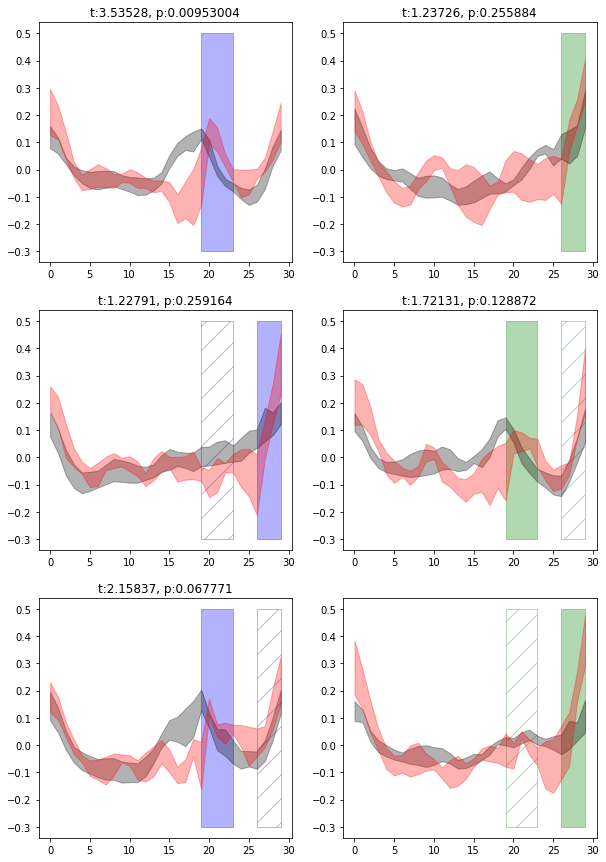

In [37]:
fig,ax = plt.subplots(3,2, figsize= [10, 15])
rz_early = (np.argwhere(sess.trial_matrices['bin_edges'][1:]>=sess.rzone_early['tfront'])[0][0], np.argwhere(sess.rzone_early['tback']<=sess.trial_matrices['bin_edges'][:-1])[0] )
rz_late = (np.argwhere(sess.trial_matrices['bin_edges'][1:]>=sess.rzone_late['tfront'])[0][0], 29 )
print(rz_early,rz_late)
x = np.arange(30)
def musem(arrays):
    mu = []
    for arr in arrays:
        mu.append(sp.stats.zscore(arr,axis=0).mean(axis=1))
    mu = np.array(mu)
    print(mu.shape)
    return mu, mu.mean(axis=0), sp.stats.sem(mu,axis=0)




ctrl_arr, mu, sem = musem(ctrl_arrays['b_l_all'])
ax[0,0].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['b_l_all'])
ax[0,0].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[0,0].fill_betweenx([-.3, .5], rz_early[0], rz_early[1],  alpha=.3, color='blue',zorder= -1)
t,p = sp.stats.ttest_ind(ctrl_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1),ko_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1))
# t,p = sp.stats.ranksums(ctrl_arr[:,rz_early[0]-5:rz_early[0]-1].sum(axis=1),ko_arr[:,rz_early[0]-5:rz_early[0]-1].sum(axis=1))
ax[0,0].set_title("t:%g, p:%g" % (t,p))




# ax[0,0].fill_betweenx([-.3,.5], rz_late[0], rz_late[1],  alpha=.3, color='blue')

ctrl_arr, mu, sem = musem(ctrl_arrays['b_r_all'])
ax[0,1].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['b_r_all'])
ax[0,1].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[0,1].fill_betweenx([-.3, .5], rz_late[0], rz_late[1],  alpha=.3, color='green',zorder= -1)
t,p = sp.stats.ttest_ind(ctrl_arr[:,rz_late[0]-5:rz_late[0]].sum(axis=1),ko_arr[:,rz_late[0]-5:rz_late[0]].sum(axis=1))
ax[0,1].set_title("t:%g, p:%g" % (t,p))


ctrl_arr, mu, sem = musem(ctrl_arrays['rev_l_all'])
ax[1,0].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['rev_l_all'])
ax[1,0].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[1,0].fill_betweenx([-.3, .5], rz_early[0], rz_early[1],  alpha=.3, color='none', hatch='/', edgecolor='blue',zorder= -1)
ax[1,0].fill_betweenx([-.3,.5], rz_late[0], rz_late[1],  alpha=.3, color='blue', zorder= -1)
t,p = sp.stats.ttest_ind(ctrl_arr[:,rz_late[0]-5:rz_late[0]].sum(axis=1),ko_arr[:,rz_late[0]-5:rz_late[0]].sum(axis=1))
ax[1,0].set_title("t:%g, p:%g" % (t,p))

ctrl_arr, mu, sem = musem(ctrl_arrays['rev_r_all'])
ax[1,1].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['rev_r_all'])
ax[1,1].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[1,1].fill_betweenx([-.3, .5], rz_late[0], rz_late[1],  alpha=.3, color='none', hatch='/', edgecolor='green',zorder= -1)
ax[1,1].fill_betweenx([-.3,.5], rz_early[0], rz_early[1],  alpha=.3, color='green', zorder= -1)
t,p = sp.stats.ttest_ind(ctrl_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1),ko_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1))
ax[1,1].set_title("t:%g, p:%g" % (t,p))


ctrl_arr, mu, sem = musem(ctrl_arrays['ret_l_all'])
ax[2,0].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['ret_l_all'])
ax[2,0].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[2,0].fill_betweenx([-.3, .5], rz_late[0], rz_late[1],  alpha=.3, color='none', hatch='/', edgecolor='blue',zorder= -1)
ax[2,0].fill_betweenx([-.3,.5], rz_early[0], rz_early[1],  alpha=.3, color='blue', zorder= -1)
t,p = sp.stats.ttest_ind(ctrl_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1),ko_arr[:,rz_early[0]-5:rz_early[0]].sum(axis=1))
ax[2,0].set_title("t:%g, p:%g" % (t,p))

ctrl_arr, mu, sem = musem(ctrl_arrays['ret_r_all'])
ax[2,1].fill_between(x, mu-sem, mu+sem, color='black', alpha = .3)
ko_arr, mu,sem = musem(ko_arrays['ret_r_all'])
ax[2,1].fill_between(x, mu-sem, mu+sem, color='red', alpha = .3)
ax[2,1].fill_betweenx([-.3, .5], rz_early[0], rz_early[1],  alpha=.3, color='none', hatch='/', edgecolor='green',zorder= -1)
ax[2,1].fill_betweenx([-.3,.5], rz_late[0], rz_late[1],  alpha=.3, color='green', zorder= -1)




    
    
    
    
#     ax[1,col].fill_betweenx(np.linspace(-.5,29.5), rz_early[0], rz_early[1],  alpha=.3, color='green')
#     ax[1,col].fill_between(np.linspace(-.5,29.5), rz_late[0], rz_late[1],  alpha=.3, hatch= '/', color='none', edgecolor='green')
# for i in range(5):
#     ax[0].plot(sp.stats.zscore(ctrl_arrays['b_l_all'][i][:,:],axis=0).mean(axis=1),color='black')
#     ax[1].plot(sp.stats.zscore(ctrl_arrays['b_r_all'][i][:,:],axis=0).mean(axis=1),color='black')
    
# for i in range(4):
#     ax[0].plot(sp.stats.zscore(ko_arrays['b_l_all'][i][:,:],axis=0).mean(axis=1),color='red')
#     ax[1].plot(sp.stats.zscore(ko_arrays['b_r_all'][i][:,:],axis=0).mean(axis=1),color='red')
    
# fig,ax = plt.subplots(1,2, figsize= [10, 5])
# for i in range(5):
#     ax[0].plot(sp.stats.zscore(ctrl_arrays['rev_l_all'][i][:,:],axis=0).mean(axis=1),color='black')
#     ax[1].plot(sp.stats.zscore(ctrl_arrays['rev_r_all'][i][:,:],axis=0).mean(axis=1),color='black')
    
# for i in range(4):
#     ax[0].plot(sp.stats.zscore(ko_arrays['rev_l_all'][i][:,:],axis=0).mean(axis=1),color='red')
#     ax[1].plot(sp.stats.zscore(ko_arrays['rev_r_all'][i][:,:],axis=0).mean(axis=1),color='red')
    
# fig,ax = plt.subplots(1,2, figsize= [10, 5])
# for i in range(5):
#     ax[0].plot(sp.stats.zscore(ctrl_arrays['ret_l_all'][i][:,:],axis=0).mean(axis=1),color='black')
#     ax[1].plot(sp.stats.zscore(ctrl_arrays['ret_r_all'][i][:,:],axis=0).mean(axis=1),color='black')
    
# for i in range(4):
#     ax[0].plot(sp.stats.zscore(ko_arrays['ret_l_all'][i][:,:],axis=0).mean(axis=1),color='red')
#     ax[1].plot(sp.stats.zscore(ko_arrays['ret_r_all'][i][:,:],axis=0).mean(axis=1),color='red')

In [38]:
df = {'ko_ctrl': [],
        'sess': [],
        'rate': [],
        'mouse': [],
        'lr': []}

for i, arr in enumerate(ctrl_arrays['b_l_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(0)
    df['mouse'].append(i)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ctrl_arrays['b_r_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(0)
    df['mouse'].append(i)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['b_l_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(0)
    df['mouse'].append(i+5)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['b_r_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(0)
    df['mouse'].append(i+5)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ctrl_arrays['rev_l_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(1)
    df['mouse'].append(i)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ctrl_arrays['rev_r_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(1)
    df['mouse'].append(i)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['rev_l_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(1)
    df['mouse'].append(i+5)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['rev_r_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(1)
    df['mouse'].append(i+5)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ctrl_arrays['ret_l_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(2)
    df['mouse'].append(i)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ctrl_arrays['ret_r_all']):
    df['ko_ctrl'].append(0)
    df['sess'].append(2)
    df['mouse'].append(i)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['ret_l_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(2)
    df['mouse'].append(i+5)
    df['lr'].append(-1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_early[0]-5:rz_early[0],:].mean(axis=0).mean(axis=0))
    
for i, arr in enumerate(ko_arrays['ret_r_all']):
    df['ko_ctrl'].append(1)
    df['sess'].append(2)
    df['mouse'].append(i+5)
    df['lr'].append(1)
    df['rate'].append(sp.stats.zscore(arr,axis=0)[rz_late[0]-5:rz_late[0],:].mean(axis=0).mean(axis=0))
    
    
df = pd.DataFrame(df)

aov = mixed_anova(data=df, dv= 'rate', between='ko_ctrl', within='sess', subject='mouse')
print(aov)

# ko_ctrl_tukey = pairwise_tukey(data=df, dv='rate', between='ko_ctrl')
stats = pairwise_ttests(data=df, dv='rate', between='ko_ctrl')
print(stats)

for day in range(3):
    print('Day %d' % day)
    print('combined arms')
#     stats = pairwise_tukey(data=df[df['sess'] == day], dv='rate', between='ko_ctrl')
    stats = pairwise_ttests(data=df[df['sess'] == day], dv='rate', between='ko_ctrl')
    print(stats)
    
    print('Left arm')
#     stats = pairwise_tukey(data=df[(df['sess'] == day) & (df['lr']== -1)], dv='rate', between='ko_ctrl')
    stats = pairwise_ttests(data=df[(df['sess'] == day) & (df['lr']== -1)], dv='rate', between='ko_ctrl')
    print(stats)
    
    print('Right arm')
#     stats = pairwise_tukey(data=df[(df['sess'] == day) & (df['lr']== 1)], dv='rate', between='ko_ctrl')
    stats = pairwise_ttests(data=df[(df['sess'] == day) & (df['lr']== 1)], dv='rate', between='ko_ctrl')
    print(stats)
    
# aov = mixed_anova(data=df, dv= 'rate', between='ko_ctrl', within='sess', subject='mouse')
# print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.059290    1    7  0.059290  9.021730  0.019840  0.563093   
1         sess  0.001172    2   14  0.000586  0.251677  0.780939  0.034706   
2  Interaction  0.001141    2   14  0.000570  0.244886  0.786077  0.033801   

       eps  
0      NaN  
1  0.71678  
2      NaN  
  Contrast  A  B  Paired  Parametric         T        dof       Tail  \
0  ko_ctrl  0  1   False        True  4.536569  39.302323  two-sided   

      p-unc     BF10    hedges  
0  0.000053  564.285  1.274804  
Day 0
combined arms
  Contrast  A  B  Paired  Parametric         T       dof       Tail     p-unc  \
0  ko_ctrl  0  1   False        True  2.878142  8.414712  two-sided  0.019521   

    BF10    hedges  
0  4.875  1.426094  
Left arm
  Contrast  A  B  Paired  Parametric        T       dof       Tail     p-unc  \
0  ko_ctrl  0  1   False        True  3.31508  4.562924  two-sided  0.024226   

    BF10    hedges  
0  4.397

In [28]:
def get_rev_plot_arr(concat_sess):
    
    trialmat = concat_sess.trial_matrices['spks']
    trialmat[np.isnan(trialmat)]=1E-3
    
    cellmask = concat_sess.fam_place_cell_mask()+concat_sess.nov_place_cell_mask()>0
    
    column = 0
    plot_arrays = np.zeros([2,18,trialmat.shape[1],cellmask.sum()])
    for day in np.unique(concat_sess.trial_info['sess_num']).tolist():
        for block in range(6):
            mask = (concat_sess.trial_info['sess_num']==day)*(concat_sess.trial_info['block_number']==block)
            l_mask = mask*(concat_sess.trial_info['LR']==-1)
            l_tmp = trialmat[l_mask,:,:].mean(axis=0)
            l_tmp = sp.stats.zscore(l_tmp[:, cellmask],axis=0)

            r_mask = mask*(concat_sess.trial_info['LR']==1)
            r_tmp = trialmat[r_mask,:,:].mean(axis=0)
            r_tmp = sp.stats.zscore(r_tmp[:, cellmask],axis=0)
            
            plot_arrays[0,column,:,:] = l_tmp
            plot_arrays[1,column,:,:] = r_tmp
            
            column +=1
    return plot_arrays

def rev_pc_plot(plot_arrays):
    fig, ax = plt.subplots(2, 18, figsize = [36,6])
    for col in range(18):
            l_tmp, r_tmp = [], []
            for mouse, plot_arr in plot_arrays.items():
                l_tmp.append(plot_arr[0, col, :, :])
                r_tmp.append(plot_arr[1, col, :, :])
            l_tmp = np.concatenate(l_tmp,axis=-1)
            r_tmp = np.concatenate(r_tmp,axis=-1)

            if col == 0:
                l_sortvec = np.argsort(np.argmax(l_tmp, axis=0))
                r_sortvec = np.argsort(np.argmax(r_tmp, axis=0))

            ax[0, col].imshow(l_tmp[:,l_sortvec].T,cmap='pink',aspect='auto',vmin=0, vmax=2)
            ax[1, col].imshow(r_tmp[:,r_sortvec].T,cmap='pink',aspect='auto',vmin=0, vmax=2)
            



ko_plot_arrays = { mouse: get_rev_plot_arr(u.single_mouse_concat_sessions(mouse,date_inds=[6, 7, 8])) for mouse in ko_mice if mouse not in ['4467975.1']}
ctrl_plot_arrays = { mouse: get_rev_plot_arr(u.single_mouse_concat_sessions(mouse,date_inds=[6, 7, 8])) for mouse in ctrl_mice}


04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_RewardReversal
06_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


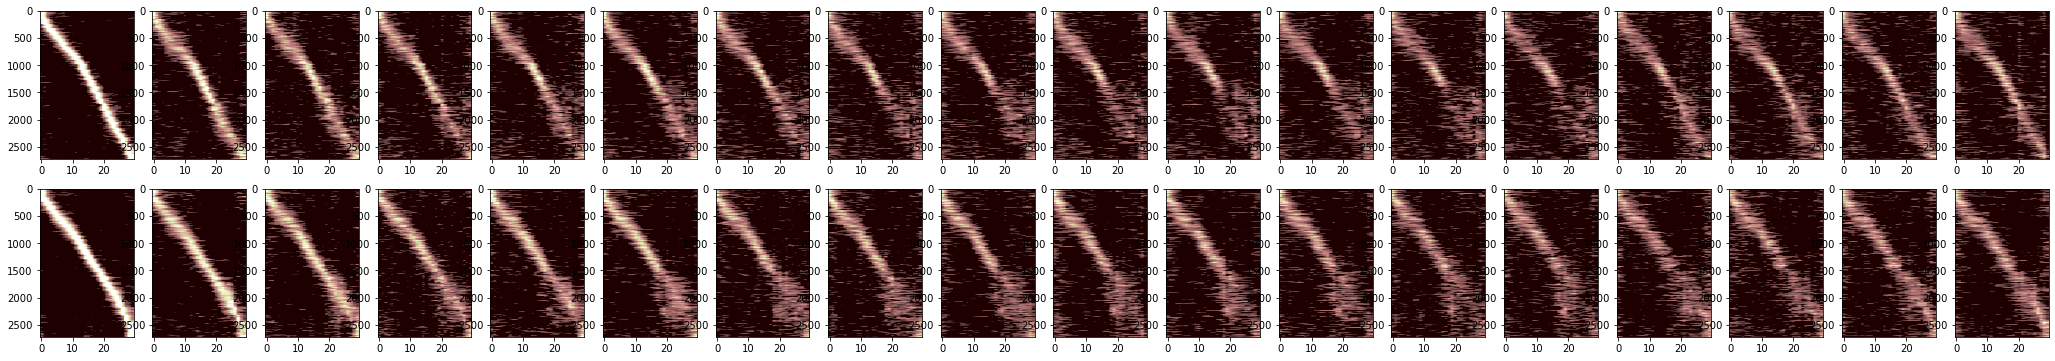

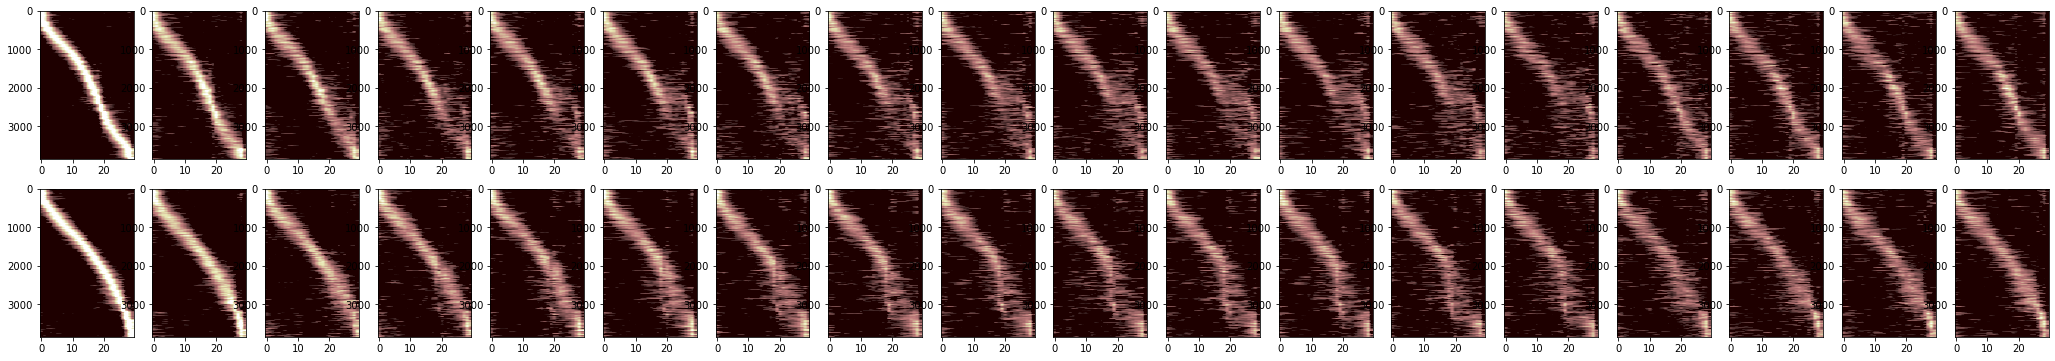

In [29]:
rev_pc_plot(ko_plot_arrays)
rev_pc_plot(ctrl_plot_arrays)

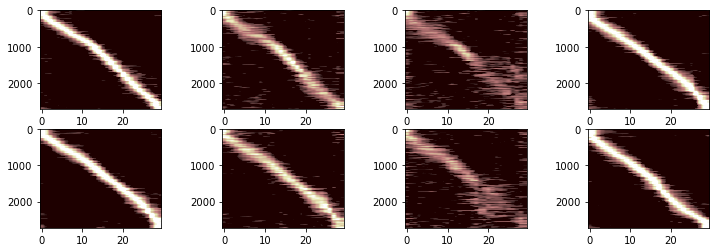

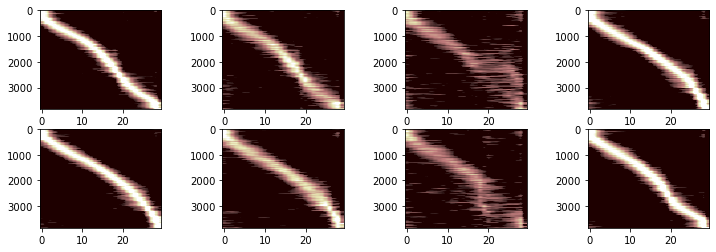

In [30]:
def rev_pc_plot_endpoints(plot_arrays):
    fig, ax = plt.subplots(2, 4, figsize = [12,4])
    fig.subplots_adjust(wspace=.5)
    for j, col in enumerate([0,1, 11, 11]):
            l_tmp, r_tmp = [], []
            for mouse, plot_arr in plot_arrays.items():
                l_tmp.append(plot_arr[0, col, :, :])
                r_tmp.append(plot_arr[1, col, :, :])
            l_tmp = np.concatenate(l_tmp,axis=-1)
            r_tmp = np.concatenate(r_tmp,axis=-1)

            if col == 0:
                l_sortvec = np.argsort(np.argmax(l_tmp, axis=0))
                r_sortvec = np.argsort(np.argmax(r_tmp, axis=0))
            if j == 3:
                l_sortvec = np.argsort(np.argmax(l_tmp, axis=0))
                r_sortvec = np.argsort(np.argmax(r_tmp, axis=0))
                
            ax[0, j].imshow(l_tmp[:,l_sortvec].T,cmap='pink',aspect='auto',vmin=0, vmax=2)
            ax[1, j].imshow(r_tmp[:,r_sortvec].T,cmap='pink',aspect='auto',vmin=0, vmax=2)
    return fig

ko_fig = rev_pc_plot_endpoints(ko_plot_arrays)
ctrl_fig = rev_pc_plot_endpoints(ctrl_plot_arrays)




# ko_fig.savefig(os.path.join(figdir,"ko_reversal_endpoints.pdf"))
# ctrl_fig.savefig(os.path.join(figdir,"ctrl_reversal_endpoints.pdf"))

In [39]:
def corr_to_baseline_rev(concat_sess):
    trialmat = concat_sess.trial_matrices['spks']
    trialmat[np.isnan(trialmat)] = 1E-3
    trialmat = sp.ndimage.filters.gaussian_filter1d(trialmat[:,12:,:],1,axis=1)

    baseline_mask = (concat_sess.trial_info['sess_num']==6)*(concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['LR']==-1)
    baseline = trialmat[baseline_mask,:,:].mean(axis=0)
    baseline = sp.stats.zscore(baseline,axis=-1)[np.newaxis,:,:]

    test_mask = concat_sess.trial_info['LR']==-1
    test_mask[(concat_sess.trial_info['sess_num']==6)*(concat_sess.trial_info['block_number']<2)] = False
    test_mask[(concat_sess.trial_info['sess_num']==8)*(concat_sess.trial_info['block_number']>2)] = False
    test = trialmat[test_mask,:,:]
    test = sp.stats.zscore(test,axis=-1)


    _corr_to_baseline = 1./test.shape[-1]*np.matmul(baseline,np.transpose(test,axes=(0,2,1)))
    corr_to_baseline = np.array([np.diag(_corr_to_baseline[trial,:,:]).mean() for trial in range(test.shape[0])])
    return corr_to_baseline

def corr_to_endpoint_rev(concat_sess):
    trialmat = concat_sess.trial_matrices['spks']
    trialmat[np.isnan(trialmat)] = 1E-3
    trialmat = sp.ndimage.filters.gaussian_filter1d(trialmat[:,12:,:],1,axis=1)

    endpoint_mask = (concat_sess.trial_info['sess_num']==8)*(concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['LR']==-1)
    endpoint = trialmat[endpoint_mask,:,:].mean(axis=0)
    endpoint = sp.stats.zscore(endpoint,axis=-1)[np.newaxis,:,:]

    test_mask = (concat_sess.trial_info['LR']==-1) *(concat_sess.trial_info['sess_num']==6)*(concat_sess.trial_info['block_number']>2)
    test_mask[(concat_sess.trial_info['sess_num']==8)*(concat_sess.trial_info['block_number']>-1)] = False
    test = trialmat[test_mask,:,:]
    test = sp.stats.zscore(test,axis=-1)


    _corr_to_endpoint = 1./test.shape[-1]*np.matmul(endpoint,np.transpose(test,axes=(0,2,1)))
    corr_to_endpoint = np.array([np.diag(_corr_to_endpoint[trial,:,:]).mean() for trial in range(test.shape[0])])
    return corr_to_endpoint

def corr_ratio_rev(concat_sess, metric = 'corr', cellavg = True):
    cellmask = concat_sess.fam_place_cell_mask()+concat_sess.nov_place_cell_mask()>0
    if not cellavg:
        trialmat = concat_sess.trial_matrices['spks_norm'][:,:,cellmask]
    else:
        trialmat = concat_sess.trial_matrices['spks'][:,:,cellmask]
    trialmat = trialmat[:,12:,:]
    trialmat[np.isnan(trialmat)] = 1E-3
    trialmat = sp.ndimage.filters.gaussian_filter1d(trialmat[:,:,:],1,axis=1)
    lickmat = concat_sess.trial_matrices['licks']
#     lickmat[np.isnan(lickmat)]=0.

    res = {}
    for lr in [-1,1]:
    
        baseline_mask = (concat_sess.trial_info['sess_num']==6)*(concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['LR']==lr)
        baseline_mask[concat_sess.trial_info['sess_num']<6]=True
        baseline = trialmat[baseline_mask,:,:].mean(axis=0,keepdims=True)
        if lr == -1:
            print('lr', concat_sess.rzone_early['t_antic'], concat_sess.rzone_early['tfront'])
            rzone_mask = (concat_sess.trial_matrices['bin_edges'][:-1]>=concat_sess.rzone_early['t_antic']) * (concat_sess.trial_matrices['bin_edges'][1:]<=concat_sess.rzone_early['tfront'])
        elif lr == 1:
            rzone_mask = (concat_sess.trial_matrices['bin_edges'][:-1]>=concat_sess.rzone_late['t_antic']) * (concat_sess.trial_matrices['bin_edges'][1:]<=concat_sess.rzone_late['tfront'])
        
        

        endpoint_mask = (concat_sess.trial_info['sess_num']==8)*(concat_sess.trial_info['block_number']<2)*(concat_sess.trial_info['LR']==lr)
        endpoint_mask[(concat_sess.trial_info['sess_num']==7)*(concat_sess.trial_info['block_number']>2)*(concat_sess.trial_info['LR']==lr)] = True
        endpoint = trialmat[endpoint_mask,:,:].mean(axis=0,keepdims=True)


        test_mask = (concat_sess.trial_info['LR']==lr) *(concat_sess.trial_info['sess_num']==6)*(concat_sess.trial_info['block_number']>2)
#         test_mask[(concat_sess.trial_info['sess_num']==7)*(concat_sess.trial_info['block_number']<3)*(concat_sess.trial_info['LR']==lr)] = True
        test = trialmat[test_mask,:,:]
        
        
        
        
        
        assert (metric in ('corr', 'cos')), "wrong metric"
                
        if metric == 'corr':
            if cellavg:
                baseline = sp.stats.zscore(baseline,axis=1)
                endpoint = sp.stats.zscore(endpoint,axis=1)
                test = sp.stats.zscore(test,axis=1)


                _corr_to_baseline = 1./test.shape[1]*np.matmul(np.transpose(test,axes=(0,2,1)),baseline)   
                _corr_to_endpoint = 1./test.shape[1]*np.matmul(np.transpose(test,axes=(0,2,1)),endpoint)
                
                corr_base_end = np.diag(1./test.shape[1]*np.squeeze(np.matmul(np.transpose(baseline,axes=(0,2,1)),endpoint)))
            else:
                baseline = sp.stats.zscore(baseline,axis=-1)
                endpoint = sp.stats.zscore(endpoint,axis=-1)
                test = sp.stats.zscore(test,axis=-1)


                _corr_to_baseline = 1./test.shape[-1]*np.matmul(baseline, np.transpose(test,axes=(0,2,1)))   
                _corr_to_endpoint = 1./test.shape[-1]*np.matmul(endpoint, np.transpose(test,axes=(0,2,1)))
                
                corr_base_end = np.diag(1./test.shape[-1]*np.squeeze(np.matmul(endpoint, np.transpose(baseline,axes=(0,2,1)))))
 
        elif metric == 'cos':
            if cellavg:
                baseline /= np.linalg.norm(baseline,ord=2,axis=1, keepdims=True) + 1E-3
                endpoint /= np.linalg.norm(endpoint,ord=2,axis=1, keepdims=True) + 1E-3
                test /= np.linalg.norm(test,ord=2,axis=1, keepdims=True) + 1E-3
            
                _corr_to_baseline = np.matmul(np.transpose(test,axes=(0,2,1)),baseline)
                _corr_to_endpoint = np.matmul(np.transpose(test,axes=(0,2,1)),endpoint)
                
                corr_base_end = np.diag(np.squeeze(np.matmul(np.transpose(baseline,axes=(0,2,1)),endpoint)))
            else:
                baseline /= np.linalg.norm(baseline,ord=2,axis=-1, keepdims=True) + 1E-3
                endpoint /= np.linalg.norm(endpoint,ord=2,axis=-1, keepdims=True) + 1E-3
                test /= np.linalg.norm(test,ord=2,axis=-1, keepdims=True) + 1E-3
            
                _corr_to_baseline = np.matmul(baseline, np.transpose(test,axes=(0,2,1)))
                _corr_to_endpoint = np.matmul(endpoint, np.transpose(test,axes=(0,2,1)))
   
                corr_base_end = np.diag(np.squeeze(np.matmul(endpoint, np.transpose(baseline,axes=(0,2,1)))))
                
            
            
            
        corr_to_baseline = np.array([np.diag(_corr_to_baseline[trial,:,:]).mean() for trial in range(test.shape[0])])
        corr_to_endpoint = np.array([np.diag(_corr_to_endpoint[trial,:,:]).mean() for trial in range(test.shape[0])])
#         print(corr_to_baseline)
#         print(corr_to_endpoint)
        
        res[lr]= {'trial': -1*np.log(np.maximum(1E-3,corr_to_endpoint)) + np.log(np.maximum(1E-3,corr_to_baseline)), 
                  'endpoints': corr_base_end}
        
    return res




ko_corr_ratio = {mouse:corr_ratio_rev(stx.utilities.single_mouse_concat_sessions(mouse,date_inds=[ 6, 7]),metric='cos', cellavg = True ) for mouse in stx.ymaze_sess_deets.KO_sessions.keys() if mouse not in ['4467975.1']}
ctrl_corr_ratio = {mouse:corr_ratio_rev(stx.utilities.single_mouse_concat_sessions(mouse,date_inds=[6, 7]),metric='cos', cellavg= True ) for mouse in stx.ymaze_sess_deets.CTRL_sessions.keys()}


04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
lr 25.67690445738824 32.67690445738824
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
lr 25.67690445738824 32.67690445738824
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
lr 25.67690445738824 32.67690445738824
04_10_2020 YMaze_LNovel
04_10_2020 YMaze_RewardReversal
05_10_2020 YMaze_RewardReversal
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
lr 25.67690445738824 32.67690445738824
05_12_2020 YMaze_LNovel
05_12_2020 YMaze_RewardReversal
06_12_2020 Y

L endpoints 2.0578500999499423 0.07861418415067171
endpoints 2.8220328553430583 0.025698198125475847
ko_slopes  [[-0.00333246 -0.00179564]
 [-0.00377905 -0.00387033]
 [-0.00374376 -0.00494687]
 [-0.00234031 -0.00863015]]
-4.930473347078943 0.0016933586134025582
-0.7996263671447923 0.45020547372918596


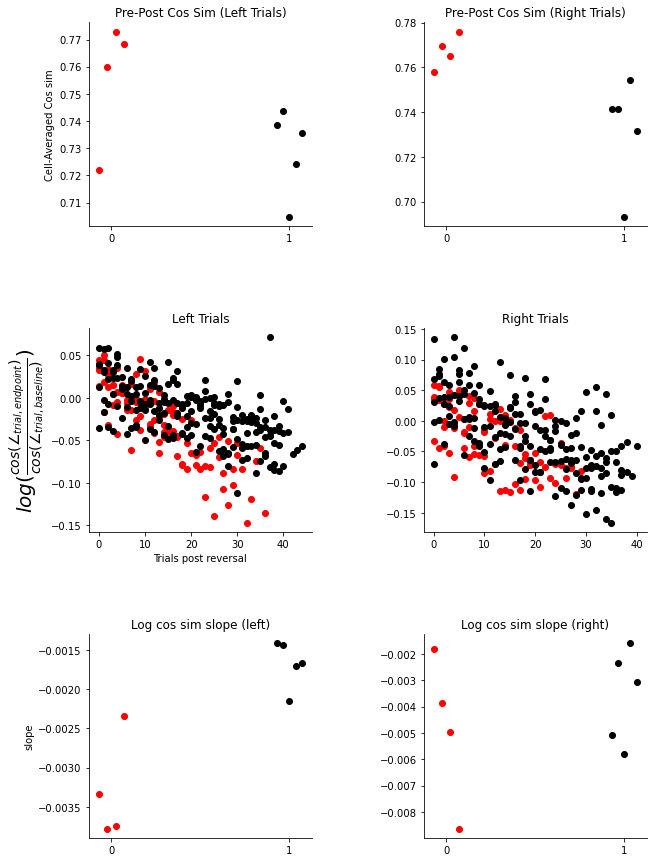

In [41]:
fig,ax = plt.subplots(3,2, figsize=[10,15])
fig.subplots_adjust(wspace=.5, hspace=.5)

rng = np.random.default_rng()


## correlation to endpoints
ko_jitter = np.linspace(-.07,.07,num=4) #.05*rng.standard_normal([4,])
ctrl_jitter = np.linspace(-.07,.07,num=5) #.05*rng.standard_normal([5,])

# [res[-1]['endpoints'] for mouse, res in ko_corr_ratio.items()]
l_ko_corr = [res[-1]['endpoints'].mean() for mouse, res in ko_corr_ratio.items() if mouse not in ['4467975.1']]
l_ctrl_corr = [res[-1]['endpoints'].mean() for mouse, res in ctrl_corr_ratio.items()]# if mouse not in ['4467975.1']]
t,p = sp.stats.ttest_ind(l_ko_corr,l_ctrl_corr)
# t,p = sp.stats.ranksums(l_ko_corr,l_ctrl_corr)
print('L endpoints', t, p)
ax[0,0].scatter(np.zeros([4,]) + ko_jitter,l_ko_corr,color='red')
ax[0,0].scatter(np.ones([5,])+ ctrl_jitter,l_ctrl_corr,color='black')
ax[0,0].set_xticks([0,1])
# ax[0,0].set_ylim([.68, .8])
ax[0,0].set_ylabel('Cell-Averaged Cos sim')
ax[0,0].set_title('Pre-Post Cos Sim (Left Trials)')



r_ko_corr = [res[1]['endpoints'].mean() for mouse, res in ko_corr_ratio.items() if mouse not in ['4467975.1']]
r_ctrl_corr = [res[1]['endpoints'].mean() for mouse, res in ctrl_corr_ratio.items()]# if mouse not in ['4467975.1']]
t,p = sp.stats.ttest_ind(r_ko_corr,r_ctrl_corr)
# t,p = sp.stats.ranksums(r_ko_corr,r_ctrl_corr)
print('endpoints', t, p)
ax[0,1].scatter(np.zeros([4,]) + ko_jitter, r_ko_corr,color='red')
ax[0,1].scatter(np.ones([5,]) + ctrl_jitter, r_ctrl_corr,color='black')
ax[0,1].set_xticks([0,1])
# ax[0,1].set_ylim([.68, .8])
ax[0,1].set_title('Pre-Post Cos Sim (Right Trials)')
    
## trial by trial change in correlation

ko_slopes =  np.zeros([4,2])
m = 0
for mouse, res  in ko_corr_ratio.items():
    for i, lr in enumerate([-1,1]):
        arr = res[lr]['trial']#[:40]
#         trials = np.arange(0,np.amin([40,arr.shape[0]]))
        trials = np.arange(0,arr.shape[0])
#         print(arr)
        if mouse not in ['4467975.1']:
            ax[1,i].scatter(trials, arr, color='red')

            reg_res = sp.stats.linregress(trials,arr)
#             print(mouse, 'lr',lr,reg_res.slope)
            ko_slopes[m,i] = reg_res.slope
            if i==1:
                m+=1
        
ctrl_slopes =  np.zeros([5,2])
for m, (mouse, res)  in enumerate(ctrl_corr_ratio.items()):
    for i, lr in enumerate([-1,1]):
        arr = res[lr]['trial']#[:40]
#         trials = np.arange(0,np.amin([40,arr.shape[0]]))
        trials = np.arange(0,arr.shape[0])
#         if mouse not in ['4467975.1']:
        ax[1,i].scatter(trials, arr, color='black')
            
        
        reg_res = sp.stats.linregress(trials,arr)
        ctrl_slopes[m,i] = reg_res.slope

ax[1,0].set_ylabel(r'$log(\frac{cos(\angle_{trial, endpoint})}{cos(\angle_{trial, baseline})})$',fontsize=20)
ax[1,0].set_title('Left Trials')
ax[1,1].set_title('Right Trials')
ax[1,0].set_xlabel('Trials post reversal')



## slopes
ax[2,0].scatter(np.zeros([4,]) + ko_jitter, ko_slopes[:,0], color='red')
ax[2,0].scatter(np.ones([5,]) + ctrl_jitter, ctrl_slopes[:,0], color='black')
ax[2,0].set_xticks([0,1])
# ax[2,0].set_ylim([-.015, 0])
ax[2,0].set_ylabel('slope')
ax[2,0].set_title('Log cos sim slope (left)')

print('ko_slopes ', ko_slopes)
ax[2,1].scatter(np.zeros([4,]) + ko_jitter, ko_slopes[:,1], color='red')
ax[2,1].scatter(np.ones([5,]) + ctrl_jitter, ctrl_slopes[:,1], color='black')
ax[2,1].set_xticks([0,1])
# ax[2,1].set_ylim([-.015, 0])
ax[2,1].set_title('Log cos sim slope (right)')

t,p = sp.stats.ttest_ind(ko_slopes[:,0],ctrl_slopes[:,0])
# t,p = sp.stats.ranksums(ko_slopes[:,0],ctrl_slopes[:,0])
print(t,p)

t,p = sp.stats.ttest_ind(ko_slopes[:,1],ctrl_slopes[:,1])
# t,p = sp.stats.ranksums(ko_slopes[:,1],ctrl_slopes[:,1])
print(t,p)
    


for i in range(3):
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

In [ ]:
# neural slope vs behavioral slope